In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
param = "Lung-AdenoCA:KRAS"

In [45]:
# Extract cancer type and gene from the parameter
cancer_type = param.split(":")[0]
gene = param.split(":")[1]
print(f"Cancer type: {cancer_type}, gene: {gene}")

Cancer type: Lung-AdenoCA, gene: KRAS


In [46]:
# input files/dirs
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
DRIVER_GENES = "../data/driver_genes"

# output files/dirs
PASS_LOCS = "../results/passenger_locations"

if not os.path.exists(PASS_LOCS):
	os.makedirs(PASS_LOCS)

In [47]:
mut_data = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
mut_data = mut_data[mut_data["gene"] == gene]
mut_data = mut_data[["Tumor_Sample_Barcode", "Patient_ID", "mutation", "driver", "has_driver", "genic_region", "CADD_score_raw"]]
# passenger mutations in the absence of driver mutations in the gene
mut_data = mut_data[(~mut_data["driver"]) & (~mut_data["has_driver"])]
mut_data["mutation_pos"] = mut_data["mutation"].apply(lambda x: int(x.split(":")[1].split("-")[0])).astype(int)
mut_data["mut"] = mut_data["mutation"].apply(lambda x: '->'.join(x.split(":")[-2:]))
mut_data.head()

,Tumor_Sample_Barcode,Patient_ID,mutation,driver,has_driver,genic_region,CADD_score_raw,mutation_pos,mut
503093,3b20d548-2a7d-4031-85a1-425ca7201d7a,DO25797,12:25401091-25401091:G:C,False,False,intronic,-0.175340,25401091,G->C
692515,49dec0c2-8e75-4f44-a253-82b2ea605890,DO25622,12:25406505-25406505:T:G,False,False,intergenic,0.177999,25406505,T->G
1022199,bd3e88b3-b37c-4641-85fa-d8125ba324ca,DO25189,12:25404117-25404117:G:T,False,False,upstream,0.472976,25404117,G->T


In [48]:
gene_data = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
gene_data = gene_data[gene_data["gene"] == gene]
gene_start = gene_data["start"].values[0]
gene_end = gene_data["end"].values[0]
gene_span = np.arange(gene_start, gene_end + 1)
print(gene_end - gene_start)

65773


2
['-', '3b20d548-2a7d-4031-85a1-425ca7201d7a', '49dec0c2-8e75-4f44-a253-82b2ea605890', 'bd3e88b3-b37c-4641-85fa-d8125ba324ca', '.']


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_72167/602672178.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_data = plot_data.append({"Tumor_Sample_Barcode": "-", "mutation_pos": gene_end+10000}, ignore_index=True)
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_72167/602672178.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_data = plot_data.append({"Tumor_Sample_Barcode": ".", "mutation_pos": gene_start-10000}, ignore_index=True)


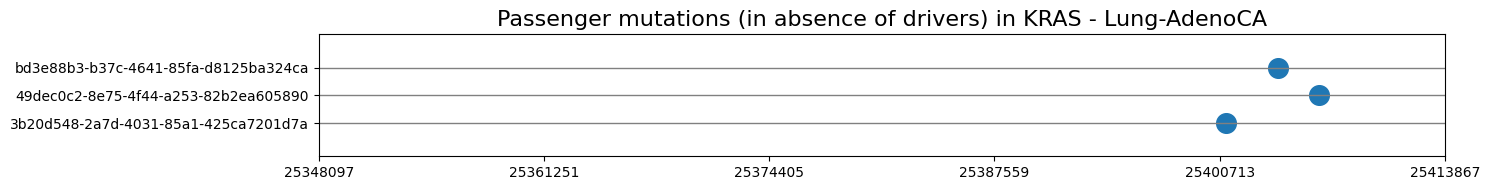

In [51]:
n_rows = mut_data["Tumor_Sample_Barcode"].nunique()
plt_height = round(n_rows * 0.5) if n_rows < 10 else round(n_rows * 0.3)
print(plt_height)
plt.figure(figsize=(15, plt_height))

plot_data = mut_data.copy()
# add dummy rows to make the plot more readable if no. of rows is small
y_order = mut_data["Tumor_Sample_Barcode"].unique()
y_order.sort()
if n_rows < 10:
	y_order = ["-"] + list(y_order) + ["."]
	print(y_order)
	plot_data = plot_data.append({"Tumor_Sample_Barcode": "-", "mutation_pos": gene_end+10000}, ignore_index=True)
	plot_data = plot_data.append({"Tumor_Sample_Barcode": ".", "mutation_pos": gene_start-10000}, ignore_index=True)
	plot_data["Tumor_Sample_Barcode"] = pd.Categorical(plot_data["Tumor_Sample_Barcode"], categories=y_order, ordered=True)
	plot_data = plot_data.sort_values(by="Tumor_Sample_Barcode")

# plot mutations
plt.scatter(
    x="mutation_pos",
    y="Tumor_Sample_Barcode",
	data=plot_data,
	s=200,  # size of the points
	marker="o",  # shape of the points
)

# add horizonal lines for each sample
if n_rows < 10:
	y_order = y_order[1:-1]  # skip the dummy rows
for sample in y_order:  # skip the dummy rows
	plt.axhline(y=sample, color='gray', linestyle='solid', linewidth=1)

interval = (gene_end - gene_start) // 5
plt.xticks(
	ticks=gene_span[::interval],
	labels=gene_span[::interval],
)
plt.yticks(ticks=y_order, labels=y_order)
plt.xlim(gene_start - 10, gene_end + 10)
plt.title(f"Passenger mutations (in absence of drivers) in {gene} - {cancer_type}", fontsize=16)
plt.tight_layout()
plt.savefig(f"{PASS_LOCS}/{cancer_type}_{gene}.png", dpi=300)